In [1]:
# add parent folder to path
import sys
import copy
sys.path.append('..')

# pytorch imports
import torch
from cloughmore.nn.models import GCMConvNet, BaselineNet
from cloughmore.nn.data import YMDatasetHDF5
import pytorch_lightning as pl

# other
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import argparse

def load_models(models_path, batch_size=None, cuda=True):
    # load model results
    model_results = pickle.load(open(models_path, 'rb'))
    
    models = []
    for r in model_results:
        if hasattr(r['hparams'], 'baseline'):
            use_baseline = r['hparams'].baseline
        else:
            use_baseline = False

        if not hasattr(r['hparams'], 'num_workers'):
            r['hparams'].num_workers = 0

        if use_baseline:
            m = BaselineNet(r['hparams'])
        else:
            m = GCMConvNet(r['hparams'])

        if batch_size is not None:
            m.hparams.batch_size = batch_size

        if cuda:
            m.cuda()

        m.load_state_dict(r['state_dict'])
        models.append(m)
    return models
    

def test_scatter(models, labels, xlabel="Predicted Value", ylabel="True Value", data='test', title=None):
    for m, l in zip(models, labels):
        # testing
        test_mse = m.mse(global_average=True)
        print("Test MSE ({}): {:.4e}".format(l, test_mse))

        X, Y_pred, Y_true = m.evaluate(data=data)
        Y_pred = np.mean(Y_pred, axis=1)
        Y_true = np.mean(Y_true, axis=1)

        plt.scatter(Y_pred.flatten(), Y_true.flatten(), marker='x', alpha=0.2, label=l)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    
    if title is not None:
        plt.title(title)
        
    x = np.linspace(*plt.gca().get_xlim())
    plt.plot(x, x, c='black', linestyle='dashed')
    
    plt.show()
    
def test_all(dataset_paths, mode_out, model_result_path, batch_size=None, cuda=True):
    # load model results
    model_results = pickle.load(open(model_result_path, 'rb'))
    

    # iterate through test sets
    full_results = []
    for path in dataset_paths:
        dataset = YMDatasetHDF5(path, mode_in='uw', mode_out=mode_out, use_idx=False)
        
        # iterate through models
        test_results = []
        for r in model_results:            
            if hasattr(r['hparams'], 'baseline'):
                use_baseline = r['hparams'].baseline
            else:
                use_baseline = False
                
            if not hasattr(r['hparams'], 'num_workers'):
                r['hparams'].num_workers = 0
            
            if use_baseline:
                m = BaselineNet(r['hparams'])
            else:
                m = GCMConvNet(r['hparams'])


            if batch_size is not None:
                m.hparams.batch_size = batch_size
                
            if cuda:
                m.cuda()

            m.load_state_dict(r['state_dict'])
            
            # update dims and change test set
            m.update_dims(dataset.dims)
            m.test_dataset = dataset
            test_mse = m.mse(global_average=True, cuda=cuda)
            print(dataset.dims, test_mse)
            test_results.append(test_mse)

        # add to full results
        entry = {
            'dataset': path,
            'dims': dataset.dims,
            'test_results': test_results
        }

        full_results.append(entry)
    
    return full_results

def plot_mse_archs(arch_results, xlabels, arch_labels, arch_colors, title, plot_all=False):
    for i, results in enumerate(arch_results):
        mses = []
        min_mse = []
        max_mse = []
        mean_mse = []
        median_mse = []
        labels = []
        for entry in results:
            min_mse.append(np.min(entry['test_results']))
            max_mse.append(np.max(entry['test_results']))
            mean_mse.append(np.mean(entry['test_results']))
            median_mse.append(np.median(entry['test_results']))
            labels.append(str(entry['dims']))
            mses.append(entry['test_results'])
            

        X = range(len(results))
        plt.fill_between(X, min_mse, max_mse, alpha=0.25, color=arch_colors[i], label=arch_labels[i])
        plt.plot(X, mean_mse, color=arch_colors[i], linestyle='dashed')
        plt.plot(X, median_mse, color=arch_colors[i])
        
        if plot_all:
            mses = np.array(mses).T
            for e in mses:
                print(X, e)
                plt.plot(X, e, color='gray', alpha=0.2)
        

    
    plt.xticks(X, xlabels)
    plt.semilogy()
    plt.grid()
    plt.legend()
    
    if title is not None:
        plt.title(title)
        
def save_mse_tables(arch_result, filename):
    min_mse = []
    max_mse = []
    mean_mse = []
    median_mse = []
    
    for entry in arch_result:
        min_mse.append(np.min(entry['test_results']))
        max_mse.append(np.max(entry['test_results']))
        mean_mse.append(np.mean(entry['test_results']))
        median_mse.append(np.median(entry['test_results']))
    
    data = np.array([list(range(len(min_mse))), min_mse, max_mse, mean_mse, median_mse]).T
    
    np.savetxt(filename, data, delimiter=" ")


def save_scatter_tables(model, filename, data='test'):
    X, Y_pred, Y_true = model.evaluate(data=data)
    Y_pred = np.mean(Y_pred, axis=1).flatten()
    Y_true = np.mean(Y_true, axis=1).flatten()
    array = np.array([Y_pred, Y_true]).T
    np.savetxt(filename, array, delimiter=" ")
    
    
def create_latex_tables(arch_results, latt_labels, metric_label, add_str):
    data = []
    for arch_result in arch_results:
        median_mse = []
        for entry in arch_result:
            median_mse.append(np.median(entry['test_results']))
        data.append(median_mse)
    data = np.array(data)
    
    line = metric_label + "{}"
    for i in range(len(arch_results)):
        line += "& {} "
    
    output = ""
    for i, latt_label in enumerate(latt_labels):
        median_mse = data[:, i]
        min_mse = np.min(median_mse)
        mse_strs = []
        for m in median_mse:
            oom = int(np.floor(np.log10(m)))
            val = m * 10 ** (-oom)
            if min_mse == m:
                m_str = "$\\mathbf{{{:3.2f} \cdot 10^{{ {:d} }}}}$".format(val, oom)
            else:
                m_str = "${:3.2f} \cdot 10^{{ {:d} }}$".format(val, oom)
            mse_strs.append(m_str)
        
        output += line.format(latt_label, *mse_strs) + add_str + " \\\\ \n"
    
    return output

def count_parameters(model_results):
    for r in model_results[:1]:
        if hasattr(r['hparams'], 'baseline'):
            m = BaselineNet(r['hparams'])
        else:
            m = GCMConvNet(r['hparams'])
        print(m.count_parameters())

def pick_best_model(model_results_path, data='val'):
    models = load_models(model_results_path)
    
    mses = []
    for m in models:
        test_mse = m.mse(global_average=True, data=data)
        print(test_mse)
        mses.append(test_mse)
    
    best_index = np.argmin(mses)
    return best_index, models[best_index]

# Paths

In [3]:
# dataset_path = "/media/data/dmueller/ym_datasets/"
dataset_path = "/path/to/datasets/"

/home/dmueller/lge-cnn/notebooks


# Wilson D2_W1

In [2]:
# datasets
dataset_paths = [
    dataset_path + "D2_8/test.hdf5",
    dataset_path + "D2_16/test.hdf5",
    dataset_path + "D2_32/test.hdf5",
    dataset_path + "D2_64/test.hdf5"
]

# model results
model_result_paths = [
    "../scripts/D2_W1_baseline_gp_results.pickle",
    "../scripts/D2_W1_lge-cnn_results.pickle"
]

# output mode
mode_out = "trW_1"

arch_results_d2_w1 = []
for model_path in model_result_paths:
    arch_result = test_all(dataset_paths, mode_out, model_path, batch_size=500)
    arch_results_d2_w1.append(arch_result)

[8 8] 1.5856363e-08
[8 8] 2.5604402e-05
[8 8] 1.9936697e-06
[8 8] 6.3941894e-07
[8 8] 5.7440982e-05
[8 8] 6.0988276e-07
[8 8] 8.350827e-08
[8 8] 1.069053e-06
[8 8] 0.00026859247
[8 8] 2.5107815e-06
[16 16] 5.3702682e-09
[16 16] 7.637719e-06
[16 16] 7.846837e-07
[16 16] 3.4480792e-07
[16 16] 3.8402908e-05
[16 16] 1.9916686e-07
[16 16] 2.5944395e-08
[16 16] 2.3599686e-07
[16 16] 0.00017655296
[16 16] 6.449993e-07
[32 32] 2.4681663e-09
[32 32] 2.5852223e-06
[32 32] 5.0668865e-07
[32 32] 2.890554e-07
[32 32] 3.284392e-05
[32 32] 4.9239954e-08
[32 32] 1.1525572e-08
[32 32] 7.733227e-08
[32 32] 0.00015028789
[32 32] 2.1898846e-07
[64 64] 1.7730586e-09
[64 64] 1.2523337e-06
[64 64] 4.487919e-07
[64 64] 2.6651952e-07
[64 64] 2.9819594e-05
[64 64] 1.908344e-08
[64 64] 7.34031e-09
[64 64] 3.639064e-08
[64 64] 0.0001402768
[64 64] 8.219719e-08
[8 8] 2.0641805e-14
[8 8] 3.7779503e-15
[8 8] 4.8762272e-15
[8 8] 6.282952e-14
[8 8] 3.4332573e-14
[8 8] 4.59936e-13
[8 8] 9.6810973e-14
[8 8] 1.2380544e-1

In [3]:
pickle.dump(arch_results_d2_w1, open("arch_d2_w1.pickle", "wb"))

In [4]:
arch_results = pickle.load(open("arch_d2_w1.pickle", "rb"))

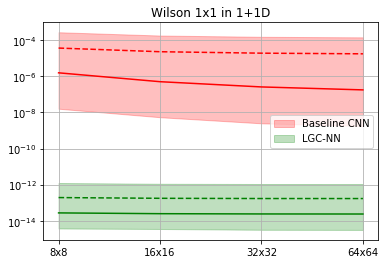

In [5]:
plot_mse_archs(arch_results, ["8x8", "16x16", "32x32", "64x64"], ["Baseline CNN", "LGE-CNN"], ["r", "g"], "Wilson 1x1 in 1+1D")

In [6]:
save_mse_tables(arch_results[0], "D2_W1_baseline_plotdata.txt")
save_mse_tables(arch_results[1], "D2_W1_lge-cnn_plotdata.txt")

1.8374012e-08
2.3486824e-05
1.747911e-06
5.8106997e-07
6.387175e-05
6.771832e-07
8.12953e-08
9.719997e-07
0.00027430832
2.6892371e-06
2.0592289e-14
3.7324075e-15
4.8483344e-15
6.359889e-14
3.426368e-14
4.603496e-13
9.612519e-14
1.2427681e-12
8.683571e-15
5.805156e-15
Test MSE (baseline): 1.5856e-08
Test MSE (lgcnn): 3.7810e-15


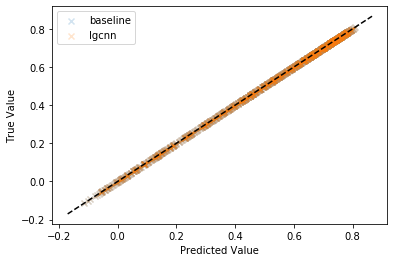

In [7]:
best_base_index, best_base_model = pick_best_model("../scripts/D2_W1_baseline_gp_results.pickle")
best_index, best_model = pick_best_model("../scripts/D2_W1_lge-cnn_results.pickle")
test_scatter([best_base_model, best_model], ["baseline", "lge-cnn"])
save_scatter_tables(best_base_model, "D2_W1_base_scatter.txt")
save_scatter_tables(best_model, "D2_W1_scatter.txt")

In [48]:
model_result_paths = [
    "../scripts/D2_W1_baseline_gp_results.pickle",
    "../scripts/D2_W1_lge-cnn_results.pickle",
]

for mp in model_result_paths:
    model_results = pickle.load(open(mp, 'rb'))
    count_parameters(model_results)

197
197


# Wilson D2_W1x2

In [8]:
# datasets
dataset_paths = [
    dataset_path + "D2_8/test.hdf5",
    dataset_path + "D2_16/test.hdf5",
    dataset_path + "D2_32/test.hdf5",
    dataset_path + "D2_64/test.hdf5"
]

# model results
model_result_paths = [
    "../scripts/D2_W1x2_baseline_gp_results.pickle",
    "../scripts/D2_W1x2_small_results.pickle",
    "../scripts/D2_W1x2_medium_results.pickle",
    "../scripts/D2_W1x2_large_results.pickle",
]

# output mode
mode_out = "trW_1x2"

arch_results_d2_w1x2 = []
for model_path in model_result_paths:
    arch_result = test_all(dataset_paths, mode_out, model_path, batch_size=50)
    arch_results_d2_w1x2.append(arch_result)

pickle.dump(arch_results_d2_w1x2, open("arch_d2_w1x2.pickle", "wb"))

[8 8] 0.0026993486
[8 8] 0.0034869686
[8 8] 0.0030976797
[8 8] 0.044781975
[8 8] 0.002649855
[8 8] 0.045290735
[8 8] 0.0029848923
[8 8] 0.0027248394
[8 8] 0.002711798
[8 8] 0.002830216
[16 16] 0.00077305007
[16 16] 0.0011693324
[16 16] 0.0012678119
[16 16] 0.041928977
[16 16] 0.00077151856
[16 16] 0.0424084
[16 16] 0.0009534214
[16 16] 0.00090350705
[16 16] 0.00065428903
[16 16] 0.000835493
[32 32] 0.00038283705
[32 32] 0.00077323144
[32 32] 0.00084148796
[32 32] 0.041145463
[32 32] 0.0003216082
[32 32] 0.04163638
[32 32] 0.0005039562
[32 32] 0.00048754306
[32 32] 0.00020512204
[32 32] 0.00040499197
[64 64] 0.00028609706
[64 64] 0.0006370405
[64 64] 0.00072196376
[64 64] 0.04074235
[64 64] 0.00019344933
[64 64] 0.041231032
[64 64] 0.00037151648
[64 64] 0.00036352547
[64 64] 7.522903e-05
[64 64] 0.00030751168
[8 8] 1.4246353e-08
[8 8] 1.8551756e-08
[8 8] 1.4610572e-08
[8 8] 1.5367576e-08
[8 8] 1.4828546e-08
[8 8] 1.3723978e-08
[8 8] 1.5174924e-08
[8 8] 1.2944878e-08
[8 8] 1.9321675e-08


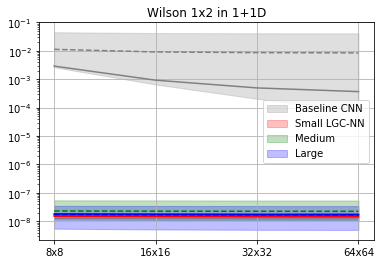

In [9]:
arch_results = pickle.load(open("arch_d2_w1x2.pickle", "rb"))
plot_mse_archs(arch_results, ["8x8", "16x16", "32x32", "64x64"], ["Baseline CNN", "Small", "Medium", "Large"], ["gray", "r", "g", "b"], "Wilson 1x2 in 1+1D")


In [11]:
save_mse_tables(arch_results[0], "D2_W1x2_baseline_plotdata.txt")
save_mse_tables(arch_results[1], "D2_W1x2_small_plotdata.txt")
save_mse_tables(arch_results[2], "D2_W1x2_medium_plotdata.txt")
save_mse_tables(arch_results[3], "D2_W1x2_large_plotdata.txt")

0.002434524
0.0030814363
0.0029582267
0.045010652
0.0024177774
0.04565403
0.0026682736
0.0025203023
0.0025023392
0.0025343152
2.4823498e-08
9.214657e-09
1.0643376e-08
8.782288e-09
3.4678127e-08
1.5600007e-08
2.2993163e-08
2.0289493e-08
5.4602407e-09
2.0969539e-08
Test MSE (baseline): 2.6499e-03
Test MSE (lgcnn): 5.4650e-09


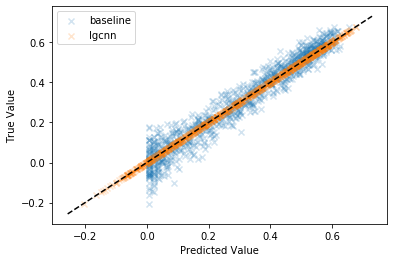

In [12]:
best_base_index, best_base_model = pick_best_model("../scripts/D2_W1x2_baseline_gp_results.pickle")
best_index, best_model = pick_best_model("../scripts/D2_W1x2_large_results.pickle")
test_scatter([best_base_model, best_model], ["baseline", "lge-cnn"])
save_scatter_tables(best_base_model, "D2_W1x2_base_scatter.txt")
save_scatter_tables(best_model, "D2_W1x2_scatter.txt")

In [13]:
print(create_latex_tables([arch_results[1], arch_results[2], arch_results[3], arch_results[0]],
                          ["$8 \\cdot 8$", "$16 \\cdot 16$", "$32 \\cdot 32$", "$64 \\cdot 64$"],
                          "", ""))

$8 \cdot 8$& $\mathbf{1.50 \cdot 10^{ -8 }}$ & $1.68 \cdot 10^{ -8 }$ & $1.80 \cdot 10^{ -8 }$ & $2.91 \cdot 10^{ -3 }$  \\ 
$16 \cdot 16$& $\mathbf{1.46 \cdot 10^{ -8 }}$ & $1.64 \cdot 10^{ -8 }$ & $1.77 \cdot 10^{ -8 }$ & $9.28 \cdot 10^{ -4 }$  \\ 
$32 \cdot 32$& $\mathbf{1.45 \cdot 10^{ -8 }}$ & $1.63 \cdot 10^{ -8 }$ & $1.75 \cdot 10^{ -8 }$ & $4.96 \cdot 10^{ -4 }$  \\ 
$64 \cdot 64$& $\mathbf{1.44 \cdot 10^{ -8 }}$ & $1.62 \cdot 10^{ -8 }$ & $1.74 \cdot 10^{ -8 }$ & $3.68 \cdot 10^{ -4 }$  \\ 



In [14]:
model_result_paths = [
    "../scripts/D2_W1x2_small_results.pickle",
    "../scripts/D2_W1x2_medium_results.pickle",
    "../scripts/D2_W1x2_large_results.pickle",
    "../scripts/D2_W1x2_baseline_gp_results.pickle"
]

for mp in model_result_paths:
    model_results = pickle.load(open(mp, 'rb'))
    count_parameters(model_results)

197
873
3089
3649


# Wilson D2_W2

In [15]:
# datasets
dataset_paths = [
    dataset_path + "/D2_8/test.hdf5",
    dataset_path + "/D2_16/test.hdf5",
    dataset_path + "/D2_32/test.hdf5",
    dataset_path + "/D2_64/test.hdf5"
        ]

# model results
model_result_paths = [
    "../scripts/D2_W2_small_results.pickle",
    "../scripts/D2_W2_medium_results.pickle",
    "../scripts/D2_W2_large_results.pickle",
    "../scripts/D2_W2_baseline_gp_results.pickle"
]

# output mode
mode_out = "trW_2"

arch_results = []
for model_path in model_result_paths:
    arch_result = test_all(dataset_paths, mode_out, model_path, batch_size=5)
    arch_results.append(arch_result)

[8 8] 5.051837e-08
[8 8] 3.8906258e-08
[8 8] 4.7027214e-08
[8 8] 3.157533e-08
[8 8] 9.101344e-08
[8 8] 5.048726e-08
[8 8] 7.644131e-08
[8 8] 1.5936098e-07
[8 8] 4.06419e-08
[8 8] 4.460068e-08
[16 16] 3.722503e-08
[16 16] 3.1780882e-08
[16 16] 3.98927e-08
[16 16] 2.5157425e-08
[16 16] 5.863372e-08
[16 16] 4.380018e-08
[16 16] 3.966341e-08
[16 16] 7.080071e-08
[16 16] 3.3877555e-08
[16 16] 3.786089e-08
[32 32] 3.4287208e-08
[32 32] 2.9642246e-08
[32 32] 3.764762e-08
[32 32] 2.3217565e-08
[32 32] 5.0935515e-08
[32 32] 4.1594372e-08
[32 32] 2.8497547e-08
[32 32] 5.442294e-08
[32 32] 3.1787486e-08
[32 32] 3.5710865e-08
[64 64] 3.2702925e-08
[64 64] 2.8838244e-08
[64 64] 3.6823877e-08
[64 64] 2.2546695e-08
[64 64] 4.8881244e-08
[64 64] 4.0836706e-08
[64 64] 2.5481011e-08
[64 64] 5.0633666e-08
[64 64] 3.104112e-08
[64 64] 3.495765e-08
[8 8] 3.620194e-08
[8 8] 6.021871e-08
[8 8] 2.383105e-08
[8 8] 1.0738504e-07
[8 8] 1.4116036e-08
[8 8] 5.4426016e-07
[8 8] 1.6257573e-08
[8 8] 2.7913862e-07
[8 

In [16]:
pickle.dump(arch_results, open("arch_d2_w2.pickle", "wb"))

In [17]:
arch_results = pickle.load(open("arch_d2_w2.pickle", "rb"))

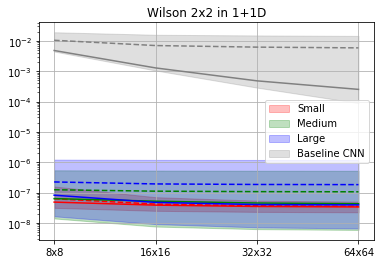

In [18]:
plot_mse_archs(arch_results, ["8x8", "16x16", "32x32", "64x64"], ["Small", "Medium", "Large", "Baseline CNN"], ["r", "g", "b", "gray"], "Wilson 2x2 in 1+1D")

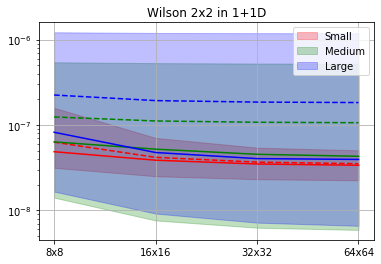

In [19]:
plot_mse_archs(arch_results[:3], ["8x8", "16x16", "32x32", "64x64"], ["Small", "Medium", "Large", "Baseline CNN"], ["r", "g", "b", "gray"], "Wilson 2x2 in 1+1D")

In [20]:
save_mse_tables(arch_results[0], "D2_W2_small_plotdata.txt")
save_mse_tables(arch_results[1], "D2_W2_medium_plotdata.txt")
save_mse_tables(arch_results[2], "D2_W2_large_plotdata.txt")
save_mse_tables(arch_results[3], "D2_W2_baseline_plotdata.txt")

In [21]:
print(create_latex_tables(arch_results,
                          ["$8 \\cdot 8$", "$16 \\cdot 16$", "$32 \\cdot 32$", "$64 \\cdot 64$"],
                          "", ""))

$8 \cdot 8$& $\mathbf{4.88 \cdot 10^{ -8 }}$ & $6.35 \cdot 10^{ -8 }$ & $8.24 \cdot 10^{ -8 }$ & $4.82 \cdot 10^{ -3 }$  \\ 
$16 \cdot 16$& $\mathbf{3.88 \cdot 10^{ -8 }}$ & $5.22 \cdot 10^{ -8 }$ & $4.77 \cdot 10^{ -8 }$ & $1.29 \cdot 10^{ -3 }$  \\ 
$32 \cdot 32$& $\mathbf{3.50 \cdot 10^{ -8 }}$ & $4.55 \cdot 10^{ -8 }$ & $4.05 \cdot 10^{ -8 }$ & $4.82 \cdot 10^{ -4 }$  \\ 
$64 \cdot 64$& $\mathbf{3.38 \cdot 10^{ -8 }}$ & $4.31 \cdot 10^{ -8 }$ & $3.96 \cdot 10^{ -8 }$ & $2.52 \cdot 10^{ -4 }$  \\ 



In [22]:
model_result_paths = [
    "../scripts/D2_W2_small_results.pickle",
    "../scripts/D2_W2_medium_results.pickle",
    "../scripts/D2_W2_large_results.pickle",
    "../scripts/D2_W2_baseline_gp_results.pickle"
]

for mp in model_result_paths:
    model_results = pickle.load(open(mp, 'rb'))
    count_parameters(model_results)

125
1305
13521
4689


0.018718475
0.018890651
0.018721513
0.0042223535
0.004303911
0.004433519
0.018711202
0.0042788694
0.004115192
0.004215414
3.4467636e-08
5.945101e-08
2.2806859e-08
1.0558685e-07
1.3569016e-08
5.3570005e-07
1.5590274e-08
2.7492393e-07
6.60328e-08
1.0660855e-07
Test MSE (baseline): 4.6219e-03
Test MSE (lgcnn): 1.4116e-08


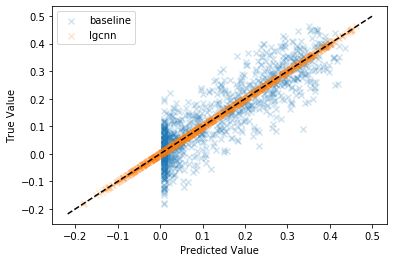

In [23]:
best_base_index, best_base_model = pick_best_model("../scripts/D2_W2_baseline_gp_results.pickle")
best_index, best_model = pick_best_model("../scripts/D2_W2_medium_results.pickle")
test_scatter([best_base_model, best_model], ["baseline", "lge-cnn"])
save_scatter_tables(best_base_model, "D2_W2_base_scatter.txt")
save_scatter_tables(best_model, "D2_W2_scatter.txt")

# D2_W4

In [24]:
# datasets
dataset_paths = [
    dataset_path + "D2_8/test.hdf5",
    dataset_path + "D2_16/test.hdf5",
    dataset_path + "D2_32/test.hdf5",
    dataset_path + "D2_64/test.hdf5"
        ]

# model results
model_result_paths = [
    "../scripts/D2_W4_small_results.pickle",
    "../scripts/D2_W4_medium_results.pickle",
    "../scripts/D2_W4_large_results.pickle",
    "../scripts/D2_W4_baseline_gp_results.pickle",
]

# output mode
mode_out = "trW_4"

arch_results_4 = []
for model_path in model_result_paths:
    arch_result = test_all(dataset_paths, mode_out, model_path, batch_size=5)
    arch_results_4.append(arch_result)

[8 8] 3.218567e-07
[8 8] 7.291456e-07
[8 8] 9.885983e-07
[8 8] 3.8958615e-07
[8 8] 2.5804857e-07
[8 8] 3.0103928e-07
[8 8] 0.004598266
[8 8] 3.5531423e-07
[8 8] 6.6798646e-07
[8 8] 0.004610294
[16 16] 9.089799e-08
[16 16] 1.509699e-07
[16 16] 2.5720811e-07
[16 16] 9.795715e-08
[16 16] 6.1715866e-08
[16 16] 7.467011e-08
[16 16] 0.001214809
[16 16] 8.178814e-08
[16 16] 2.26838e-07
[16 16] 0.0012060473
[32 32] 3.6808117e-08
[32 32] 6.9942516e-08
[32 32] 1.16516574e-07
[32 32] 2.991635e-08
[32 32] 1.7128182e-08
[32 32] 2.4819524e-08
[32 32] 0.00030399294
[32 32] 2.0449985e-08
[32 32] 1.0966086e-07
[32 32] 0.00029297554
[64 64] 2.2285738e-08
[64 64] 4.03666e-08
[64 64] 7.8971496e-08
[64 64] 1.3505778e-08
[64 64] 5.361666e-09
[64 64] 1.1807475e-08
[64 64] 7.577245e-05
[64 64] 5.2535696e-09
[64 64] 8.465537e-08
[64 64] 7.704557e-05
[8 8] 3.661661e-07
[8 8] 3.581388e-07
[8 8] 2.8965277e-07
[8 8] 7.216267e-07
[8 8] 4.5274936e-07
[8 8] 5.8727574e-07
[8 8] 3.7387628e-07
[8 8] 1.0947075e-06
[8 8] 

In [25]:
pickle.dump(arch_results_4, open("arch_d2_w4.pickle", "wb"))

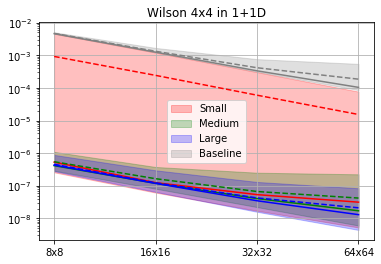

In [26]:
arch_results_4 = pickle.load(open("arch_d2_w4.pickle", "rb"))
plot_mse_archs(arch_results_4, ["8x8", "16x16", "32x32", "64x64"], ["Small", "Medium", "Large", "Baseline"], ["r", "g", "b", "gray"], "Wilson 4x4 in 1+1D")

In [27]:
save_mse_tables(arch_results_4[0], "D2_W4_small_plotdata.txt")
save_mse_tables(arch_results_4[1], "D2_W4_medium_plotdata.txt")
save_mse_tables(arch_results_4[2], "D2_W4_large_plotdata.txt")
save_mse_tables(arch_results_4[3], "D2_W4_baseline_plotdata.txt")

In [28]:
print(create_latex_tables(arch_results_4,
                          ["$8 \\cdot 8$", "$16 \\cdot 16$", "$32 \\cdot 32$", "$64 \\cdot 64$"],
                          "", ""))

$8 \cdot 8$& $5.29 \cdot 10^{ -7 }$ & $\mathbf{4.13 \cdot 10^{ -7 }}$ & $4.29 \cdot 10^{ -7 }$ & $4.61 \cdot 10^{ -3 }$  \\ 
$16 \cdot 16$& $1.24 \cdot 10^{ -7 }$ & $1.18 \cdot 10^{ -7 }$ & $\mathbf{1.18 \cdot 10^{ -7 }}$ & $1.25 \cdot 10^{ -3 }$  \\ 
$32 \cdot 32$& $5.34 \cdot 10^{ -8 }$ & $4.05 \cdot 10^{ -8 }$ & $\mathbf{3.46 \cdot 10^{ -8 }}$ & $3.34 \cdot 10^{ -4 }$  \\ 
$64 \cdot 64$& $3.13 \cdot 10^{ -8 }$ & $1.70 \cdot 10^{ -8 }$ & $\mathbf{1.30 \cdot 10^{ -8 }}$ & $1.04 \cdot 10^{ -4 }$  \\ 



In [29]:
model_result_paths = [
    "../scripts/D2_W4_small_results.pickle",
    "../scripts/D2_W4_medium_results.pickle",
    "../scripts/D2_W4_large_results.pickle",
    "../scripts/D2_W4_baseline_gp_results.pickle"
]
for mp in model_result_paths:
    model_results = pickle.load(open(mp, 'rb'))
    count_parameters(model_results)

465
4833
39905
6769


0.0043191756
0.004301387
0.004319271
0.00456653
0.0045797983
0.0044040843
0.004341788
0.0046302574
0.0043064323
0.0042790184
4.864215e-07
2.5954964e-07
2.5370008e-07
3.6866675e-07
4.629455e-07
8.8836475e-07
3.091563e-07
4.092556e-07
2.680423e-07
4.6528208e-07
Test MSE (baseline): 4.6000e-03
Test MSE (lgcnn): 2.8195e-07


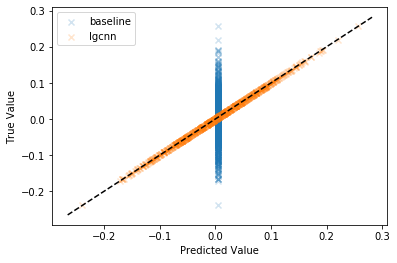

In [30]:
best_base_index, best_base_model = pick_best_model("../scripts/D2_W4_baseline_gp_results.pickle")
best_index, best_model = pick_best_model("../scripts/D2_W4_large_results.pickle")
test_scatter([best_base_model, best_model], ["baseline", "lge-cnn"])
save_scatter_tables(best_base_model, "D2_W4_base_scatter.txt")
save_scatter_tables(best_model, "D2_W4_scatter.txt")

# D4_W2

In [31]:
# datasets
dataset_paths = [
    dataset_path + "D4_4x8p3/test.hdf5",
    dataset_path + "D4_6x8p3/test.hdf5",
    dataset_path + "D4_8x16p3/test.hdf5"
]

# model results
model_result_paths = [
    "../scripts/D4_W2_small_results.pickle",
    "../scripts/D4_W2_medium_results.pickle",
]

# output mode
mode_out = "trW_2"

arch_results_d4_w2 = []
for model_path in model_result_paths:
    arch_result = test_all(dataset_paths, mode_out, model_path, batch_size=1, cuda=True)
    arch_results_d4_w2.append(arch_result)

pickle.dump(arch_results_d4_w2, open("arch_d4_w2.pickle", "wb"))

[4 8 8 8] 1.3658535e-08
[4 8 8 8] 1.1066238e-06
[4 8 8 8] 3.951088e-09
[4 8 8 8] 9.161408e-08
[4 8 8 8] 5.8909148e-08
[6 8 8 8] 1.40480285e-08
[6 8 8 8] 1.106566e-06
[6 8 8 8] 4.1226076e-09
[6 8 8 8] 9.122936e-08
[6 8 8 8] 5.8414493e-08
[ 8 16 16 16] 1.3693867e-08
[ 8 16 16 16] 1.1048705e-06
[ 8 16 16 16] 4.0007135e-09
[ 8 16 16 16] 9.086018e-08
[ 8 16 16 16] 5.572812e-08
[4 8 8 8] 4.526499e-08
[4 8 8 8] 1.077654e-07
[4 8 8 8] 2.767296e-05
[4 8 8 8] 3.8234838e-08
[4 8 8 8] 8.087852e-08
[6 8 8 8] 4.7323535e-08
[6 8 8 8] 9.480414e-08
[6 8 8 8] 1.7685063e-05
[6 8 8 8] 2.9629097e-08
[6 8 8 8] 6.180399e-08
[ 8 16 16 16] 3.7868435e-08
[ 8 16 16 16] 4.0487016e-08
[ 8 16 16 16] 5.121178e-06
[ 8 16 16 16] 1.7240378e-08
[ 8 16 16 16] 3.0176494e-08


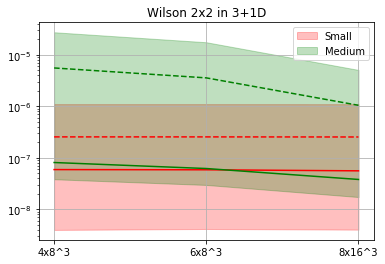

In [32]:
arch_results_d4_w2 = pickle.load(open("arch_d4_w2.pickle", "rb"))
plot_mse_archs(arch_results_d4_w2, ["4x8^3", "6x8^3", "8x16^3"], ["Small", "Medium"], ["r", "g", "b"], "Wilson 2x2 in 3+1D")

In [33]:
save_mse_tables(arch_results_d4_w2[0], "D4_W2_small_plotdata.txt")
save_mse_tables(arch_results_d4_w2[1], "D4_W2_medium_plotdata.txt")

In [34]:
print(create_latex_tables(arch_results_d4_w2,
                          ["$4 \\cdot 8^3$", "$6 \\cdot 8^3$", "$8 \\cdot 16^3$"],
                          "", add_str=""))

$4 \cdot 8^3$& $\mathbf{5.89 \cdot 10^{ -8 }}$ & $8.09 \cdot 10^{ -8 }$  \\ 
$6 \cdot 8^3$& $\mathbf{5.84 \cdot 10^{ -8 }}$ & $6.18 \cdot 10^{ -8 }$  \\ 
$8 \cdot 16^3$& $5.57 \cdot 10^{ -8 }$ & $\mathbf{3.79 \cdot 10^{ -8 }}$  \\ 



In [35]:
model_result_paths = [
    "../scripts/D4_W2_small_results.pickle",
    "../scripts/D4_W2_medium_results.pickle",
]

for mp in model_result_paths:
    model_results = pickle.load(open(mp, 'rb'))
    count_parameters(model_results)

1449
7393


1.3705581e-08
1.1064337e-06
4.064389e-09
9.117188e-08
5.9579627e-08
Test MSE (lgcnn): 3.9511e-09


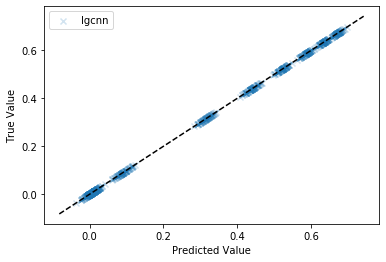

In [49]:
best_index, best_model = pick_best_model("../scripts/D4_W2_small_results.pickle")
test_scatter([best_model], ["lge-cnn"])
save_scatter_tables(best_model, "D4_W2_scatter.txt")

Test MSE (test): 3.8235e-08


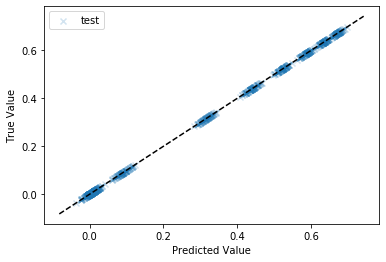

In [36]:
model_result_paths = [
    "../scripts/D4_W2_small_results.pickle",
    "../scripts/D4_W2_medium_results.pickle",
]
models = load_models(model_result_paths[1])
test_scatter([models[3]], ["test"])

# D4_W4

In [ ]:
# datasets
dataset_paths = [
    dataset_path + "D4_4x8p3/test.hdf5",
    dataset_path + "D4_6x8p3/test.hdf5",
    dataset_path + "D4_8x16p3/test.hdf5"
]

# model results
model_result_paths = [
    "../scripts/D4_W4_small_results.pickle",
    "../scripts/D4_W4_medium_results.pickle",
]

# output mode
mode_out = "trW_4"

arch_results_d4_w4 = []
for model_path in model_result_paths:
    arch_result = test_all(dataset_paths, mode_out, model_path, batch_size=1, cuda=True)
    arch_results_d4_w4.append(arch_result)

pickle.dump(arch_results_d4_w4, open("arch_d4_w4.pickle", "wb"))

[4 8 8 8] 3.9650598e-07
[4 8 8 8] 0.00022565381
[4 8 8 8] 8.8614385e-08
[4 8 8 8] 1.2647328e-07
[4 8 8 8] 5.040588e-07
[6 8 8 8] 4.2008656e-07
[6 8 8 8] 0.00017568746
[6 8 8 8] 8.967372e-08
[6 8 8 8] 1.2760742e-07
[6 8 8 8] 5.2823765e-07
[ 8 16 16 16] 4.0664074e-07
[ 8 16 16 16] 3.98528e-05
[ 8 16 16 16] 8.168956e-08
[ 8 16 16 16] 1.2227743e-07


In [ ]:
arch_results_d4_w4 = pickle.load(open("arch_d4_w4.pickle", "rb"))
plot_mse_archs(arch_results_d4_w4, ["4x8^3", "6x8^3", "8x16^3"], ["Small", "Medium"], ["r", "g", "b"], "Wilson 4x4 in 3+1D")

In [ ]:
save_mse_tables(arch_results_d4_w4[0], "D4_W4_small_plotdata.txt")
save_mse_tables(arch_results_d4_w4[1], "D4_W4_medium_plotdata.txt")

In [ ]:
print(create_latex_tables(arch_results_d4_w4,
                          ["$4 \\cdot 8^3$", "$6 \\cdot 8^3$", "$8 \\cdot 16^3$"],
                          "", add_str=""))

In [ ]:
model_result_paths = [
    "../scripts/D4_W4_small_results.pickle",
    "../scripts/D4_W4_medium_results.pickle",
]

for mp in model_result_paths:
    model_results = pickle.load(open(mp, 'rb'))
    count_parameters(model_results)

3.9776586e-07
0.00022745648
8.6960604e-08
1.2866396e-07
5.0004775e-07
Test MSE (lgcnn): 8.8601e-08


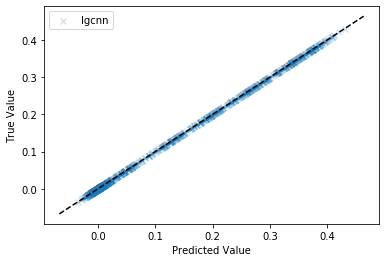

In [50]:
best_index, best_model = pick_best_model("../scripts/D4_W4_small_results.pickle")
test_scatter([best_model], ["lge-cnn"])
save_scatter_tables(best_model, "D4_W4_scatter.txt")

# Topological charge (plaq)

In [ ]:
# datasets
dataset_paths = [
    dataset_path + "D4_4x8p3/test.hdf5",
    dataset_path + "D4_6x8p3/test.hdf5",
    dataset_path + "D4_8x16p3/test.hdf5"
]

# model results
model_result_paths = [
    "../scripts/D4_QP_results.pickle",
]

# output mode
mode_out = "QP"

arch_results_d4_qp = []
for model_path in model_result_paths:
    arch_result = test_all(dataset_paths, mode_out, model_path, batch_size=1, cuda=True)
    arch_results_d4_qp.append(arch_result)

pickle.dump(arch_results_d4_qp, open("arch_d4_qp.pickle", "wb"))

In [ ]:
arch_results_d4_qp = pickle.load(open("arch_d4_qp.pickle", "rb"))
plot_mse_archs(arch_results_d4_qp, ["4x8^3", "6x8^3", "8x16^3"], ["LGE-CNN"], ["r"], "q_plaq 3+1D", plot_all=True)

In [ ]:
print(create_latex_tables(arch_results_d4_qp,
                          ["$4 \\cdot 8^3$", "$6 \\cdot 8^3$", "$8 \\cdot 16^3$"],
                          "", add_str=""))

In [ ]:
model_result_paths = [
    "../scripts/D4_QP_results.pickle",
]

for mp in model_result_paths[0:1]:
    model_results = pickle.load(open(mp, 'rb'))
    count_parameters(model_results)

In [ ]:
save_mse_tables(arch_results_d4_qp[0], "D4_QP_plotdata.txt")

In [ ]:
best_index, best_model = pick_best_model("../scripts/D4_QP_results.pickle")
test_scatter([best_model], ["lge-cnn"])
save_scatter_tables(best_model, "D2_QP_scatter.txt")

5.430405e-09
0.0006418301
3.0864044e-08
3.5820533e-09
3.819834e-09
Test MSE (lgcnn): 3.5814e-09


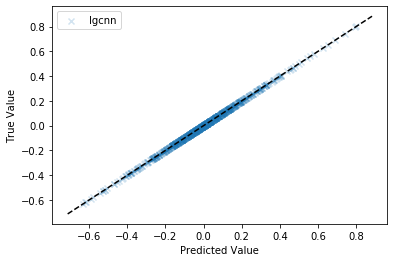

In [51]:
best_index, best_model = pick_best_model("../scripts/D4_QP_results.pickle")
test_scatter([best_model], ["lge-cnn"])
save_scatter_tables(best_model, "D4_QP_scatter.txt")